In [1]:
import itertools
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
df = pd.read_csv("video_count.csv")
df['date'] = pd.to_datetime(df.date)

In [5]:
df.head()

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08


In [6]:
def extract_counts_statistics(df):
    """
    input:
        DataFrame of a certain video (same video_id)
    output:
        25th,50th,75th,mean of that video's view_count
        25th,50th,75th,mean of that video's view_count's change rate
    """
    counts = df.sort_values(by='date')['count'].astype(np.float)
    qs = [25,50,75]

    # ************* count's statistics ************* #
    cnt_percentiles = np.percentile(counts,qs)
    d = {'cnt_{}th'.format(q):p for q,p in itertools.izip(qs,cnt_percentiles)}
    d['cnt_mean'] = counts.mean()
    # ************* count's change rate's statistics ************* #
    # change rate = 'current view counts'/'previous view counts'
    cnts_prev = counts.iloc[:-1]
    cnts_current = counts.iloc[1:]
    # divide by values, not match by index
    change_rates = cnts_current.values / cnts_prev.values

    chg_percentiles = np.percentile(change_rates,qs)
    for q,p in itertools.izip(qs,chg_percentiles):
        # 'rch' stands for 'rate of change'
        d['rch_{}th'.format(q)] = p
    d['rch_mean'] = change_rates.mean()

    return pd.Series(d)

In [7]:
df2 = df.groupby('video_id').apply(extract_counts_statistics)

In [8]:
df2.head()

,cnt_25th,cnt_50th,cnt_75th,cnt_mean,rch_25th,rch_50th,rch_75th,rch_mean
video_id,,,,,,,,
1,41099.0,65907.0,96335.0,7.063560e+04,0.813619,0.848616,0.932023,0.872563
2,1673415.5,1718352.0,1782226.5,1.737141e+06,0.938541,0.956124,1.030687,0.985816
3,2132336.5,2247587.0,2436222.5,2.292781e+06,0.971707,0.998932,1.056393,1.008923
4,2611162.0,2719547.0,2880268.5,2.740392e+06,0.972875,1.001606,1.050860,1.011310
5,255574.5,388594.0,609508.0,4.479973e+05,0.822568,0.866553,0.987271,0.888189


* hot - cnt25, 50, 75 and mean >= 75% videos, rch_25, 50, 75, mean >= 50% videos
* stable and popular - cnt25, 50, 75 and mean >= 75% videos
* everything else

In [9]:
df2.loc[(df2.cnt_25th >= df2.cnt_25th.quantile(.75)) & (df2.cnt_50th >= df2.cnt_50th.quantile(.75)) 
        & (df2.cnt_75th >= df2.cnt_75th.quantile(.75)) & (df2.cnt_mean >= df2.cnt_mean.quantile(.75)) 
        ,'category'] = "stable"

In [10]:
df2.loc[(df2.cnt_25th >= df2.cnt_25th.quantile(.75)) & (df2.cnt_50th >= df2.cnt_50th.quantile(.75)) 
        & (df2.cnt_75th >= df2.cnt_75th.quantile(.75)) & (df2.cnt_mean >= df2.cnt_mean.quantile(.75)) &
        (df2.rch_25th >= df2.rch_25th.quantile(.50)) & (df2.rch_50th >= df2.rch_50th.quantile(.50)) 
        & (df2.rch_75th >= df2.rch_75th.quantile(.50)) & (df2.rch_mean >= df2.rch_mean.quantile(.50)) 
        ,'category'] = "hot"

In [11]:
df2.category = df2.category.fillna('else')

In [12]:
df2.category.value_counts()

else      2169
hot        329
stable     287
Name: category, dtype: int64

In [13]:
df2.loc[(df2.cnt_25th >= df2.cnt_25th.quantile(.75)) & (df2.cnt_50th >= df2.cnt_50th.quantile(.75)) 
        & (df2.cnt_75th >= df2.cnt_75th.quantile(.75)) & (df2.cnt_mean >= df2.cnt_mean.quantile(.75)) &
        (df2.rch_25th >= df2.rch_25th.quantile(.50)) & (df2.rch_50th >= df2.rch_50th.quantile(.50)) 
        & (df2.rch_75th >= df2.rch_75th.quantile(.50)) & (df2.rch_mean >= df2.rch_mean.quantile(.50)) 
        ,'is_hot'] = 1

In [14]:
df2.is_hot = df2.is_hot.fillna(0)

In [15]:
df2.is_hot.value_counts()

0.0    2456
1.0     329
Name: is_hot, dtype: int64

In [16]:
features = pd.read_csv("video_features.csv",index_col='video_id')

In [17]:
main = df2.join(features)

In [18]:
main.head()

,cnt_25th,cnt_50th,cnt_75th,cnt_mean,rch_25th,rch_50th,rch_75th,rch_mean,category,is_hot,video_length,video_language,video_upload_date,video_quality
video_id,,,,,,,,,,,,,,
1,41099.0,65907.0,96335.0,7.063560e+04,0.813619,0.848616,0.932023,0.872563,else,0.0,1496,Es,2014-12-04,720p
2,1673415.5,1718352.0,1782226.5,1.737141e+06,0.938541,0.956124,1.030687,0.985816,stable,0.0,751,Cn,2014-12-14,480p
3,2132336.5,2247587.0,2436222.5,2.292781e+06,0.971707,0.998932,1.056393,1.008923,hot,1.0,807,En,2014-12-15,1080p
4,2611162.0,2719547.0,2880268.5,2.740392e+06,0.972875,1.001606,1.050860,1.011310,hot,1.0,545,En,2014-12-11,360p
5,255574.5,388594.0,609508.0,4.479973e+05,0.822568,0.866553,0.987271,0.888189,else,0.0,953,En,2014-12-10,1080p


In [19]:
language = pd.get_dummies(main['video_language'],prefix = 'video_language')
main = pd.concat([main,language],axis = 1)

In [20]:
main['video_upload_date'] = pd.to_datetime(main.video_upload_date)

In [21]:
main['upload_weekday'] = main.video_upload_date.dt.weekday_name

In [22]:
weekday = pd.get_dummies(main['upload_weekday'],prefix = 'upload_weekday')
main = pd.concat([main,weekday],axis = 1)

In [23]:
quality = pd.get_dummies(main['video_quality'],prefix = 'video_quality')
main = pd.concat([main,quality],axis = 1)

In [24]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2785 entries, 1 to 3000
Data columns (total 33 columns):
cnt_25th                    2785 non-null float64
cnt_50th                    2785 non-null float64
cnt_75th                    2785 non-null float64
cnt_mean                    2785 non-null float64
rch_25th                    2785 non-null float64
rch_50th                    2785 non-null float64
rch_75th                    2785 non-null float64
rch_mean                    2785 non-null float64
category                    2785 non-null object
is_hot                      2785 non-null float64
video_length                2785 non-null int64
video_language              2785 non-null object
video_upload_date           2785 non-null datetime64[ns]
video_quality               2785 non-null object
video_language_Cn           2785 non-null uint8
video_language_De           2785 non-null uint8
video_language_En           2785 non-null uint8
video_language_Es           2785 non-null uint8

In [25]:
X = main[['video_length','video_quality_1080p','video_quality_240p','video_quality_360p','video_quality_480p','video_quality_720p',
          'video_language_Cn','video_language_De','video_language_En','video_language_Es',
         'video_language_Fr','video_language_Other','upload_weekday_Friday','upload_weekday_Monday','upload_weekday_Saturday',
         'upload_weekday_Sunday','upload_weekday_Thursday','upload_weekday_Tuesday','upload_weekday_Wednesday']]

In [26]:
y = main['is_hot']

In [39]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=10,min_samples_split=30)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [40]:
feat_importances = pd.Series( dt.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False,inplace=True)
feat_importances

video_length                0.703613
video_language_Cn           0.127676
video_quality_240p          0.068047
video_quality_480p          0.059597
upload_weekday_Saturday     0.032778
video_language_Other        0.008288
video_language_De           0.000000
video_quality_1080p         0.000000
video_quality_360p          0.000000
video_quality_720p          0.000000
upload_weekday_Wednesday    0.000000
video_language_En           0.000000
upload_weekday_Tuesday      0.000000
video_language_Fr           0.000000
upload_weekday_Friday       0.000000
upload_weekday_Monday       0.000000
upload_weekday_Sunday       0.000000
upload_weekday_Thursday     0.000000
video_language_Es           0.000000
dtype: float64

In [41]:
from sklearn.externals import joblib
joblib.dump(dt, 'dt.pkl') 

['dt.pkl']

In [42]:
from sklearn.externals import joblib
dt = joblib.load('dt.pkl') 

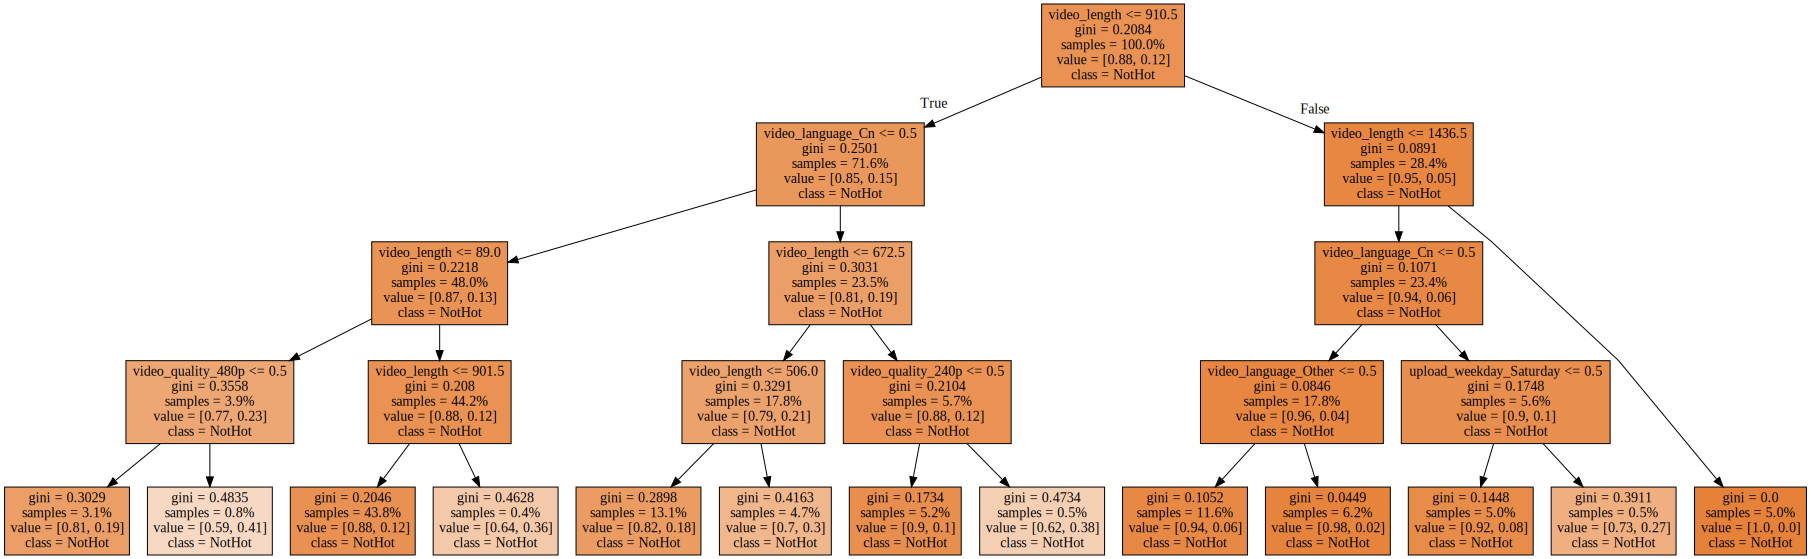

In [43]:
from graphviz import Source
Source(export_graphviz(dt,out_file=None,feature_names=X.columns,class_names=['NotHot','Hot'],
                       proportion=True,leaves_parallel=True,filled=True
                ))